In [1]:
! nvidia-smi

Thu Jan 30 03:10:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:03:00.0 Off |                  N/A |
|  0%   22C    P8             16W /  350W |       2MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies if haven't done it already for this Jupyter session

In [ ]:
%pip install -q --upgrade pip
# The version of the torch and torchvision packages must be compatible with the version of the CUDA toolkit installed on the system
%pip install -q "unsloth[cu124-torch240] @ git+https://github.com/unslothai/unsloth.git"

# Overlap Density Pipeline

### Attention: Execute the code below only once per session!

In [1]:
import os

# Move one level up and enter the src folder
os.chdir(os.path.join(os.path.dirname(os.getcwd())))

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch
from ruptures import Binseg
from dataclasses import dataclass
from typing import Optional, Union, Literal
from simple_parsing import Serializable
from pathlib import Path
from tqdm import tqdm
from datasets import DatasetDict, load_from_disk


from src.ds_registry import load_and_process_dataset
from src.probe import ProbeConfig, LogisticProbeConfig, PROBES
from src.model_unsloth import ModelConfig, load_model_and_save_activations # Unsloth requires to have NVIDIA's GPU available and CUDA installed
from src.data_selection_linear_probing import (
    detect_and_partition,
    detect_hard_nonhard,
    detect_overlap_easy,
    partition_indices_with_ratio,
    setup_arms,
    StrategyTracker
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## Define Config

In [3]:
@dataclass
class Config(Serializable):
    weak_model_name: str = "unsloth/Qwen2.5-0.5B-bnb-4bit"
    strong_model_name: str = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"
    # name of the dataset to use
    dataset: str = "amazon_polarity"
    seed: Optional[int] = 42
    n_train: int = 10_000
    n_val: int = 1_000
    n_test: int = 5_000
    # when "train", it uses the training set to generate predictions
    # otherwise it uses n_predict held out examples
    n_predict: Union[Literal["train"], int] = 0
    results_folder: str = "./results"
    enable_lora: bool = True

    probe_cfg: ProbeConfig = "logreg"

    @property
    def run_name(self) -> str:
        return f"{self.dataset}_{self.seed}"
    

cfg = Config(
    dataset="amazon_polarity",
    n_train=10_000,
    n_val=1_000,
    n_test=5_000,
    seed=42,
    enable_lora=True,
)

print(f"Using seed: {cfg.seed}")

Using seed: 42


## Load & process dataset
(This step requires CPU only)

Note: If you have splits saved for any given dataset and seed but the code is trying to load and process a dataset again - please restart Jupyter kernel and try again

In [4]:
cfg_name = f"{cfg.run_name}_{cfg.weak_model_name.split('/')[-1]}_{cfg.strong_model_name.split('/')[-1]}"

# Load or create dataset splits | Make a function for this!
save_path = Path(cfg.results_folder) / cfg_name / "splits"
if os.path.exists(save_path):
    print(f"Loading splits from {save_path}")
    splits = load_from_disk(str(save_path))
else:
    print(f"Loading and processing dataset {cfg.dataset}")
    splits = load_and_process_dataset(cfg.dataset, cfg.n_train, cfg.n_val, cfg.n_test, cfg.n_predict)
    train_halves = splits["train"].train_test_split(test_size=0.5, seed=cfg.seed)
    splits["weak_train"] = train_halves["train"]
    splits["strong_train"] = train_halves["test"]
    cols = ["hard_label", "txt"]
    splits = splits.select_columns(cols).rename_column("hard_label", "labels")

    for split in splits:
        splits[split] = splits[split].add_column("gt_labels", splits[split]["labels"])

    print(f"Example:\n\n{splits['strong_train'][0]['txt']}\n\nLabel: {splits['strong_train'][0]['labels']}")
    print(f"Saving splits to {save_path}")
    save_path.mkdir(parents=True, exist_ok=True)
    splits.save_to_disk(str(save_path))

Loading splits from results/amazon_polarity_42_Qwen2.5-0.5B-bnb-4bit_Meta-Llama-3.1-8B-bnb-4bit/splits


## Load model & collect activation

In [5]:
# Creates a tensor directly on the GPU to allocate some GPU memory | Used to avoid torch.cuda.max_memory_allocated() to return 0 and cause "Div by 0 err"
if torch.cuda.max_memory_allocated() == 0:
    dummy_tensor = torch.randn(69, device='cuda')

In [ ]:
# Define the model configurations and run names
def get_model_and_run_name(model_name, current_name):
    model_last = model_name.split("/")[-1]
    model_cfg = ModelConfig(name=model_name, enable_lora=cfg.enable_lora)
    run_name = f"{current_name}-{cfg.run_name}-{cfg.dataset}-{model_last}"
    return model_cfg, run_name

# Define weak and strong (W2S) model configurations and training arguments
weak_model_cfg, weak_run_name = get_model_and_run_name(cfg.weak_model_name, "weak")
w2s_model_cfg, w2s_run_name = get_model_and_run_name(cfg.strong_model_name, "strong")

# Do sampling for faster check
w2s_train = splits["strong_train"]


weak_act_ds_dict = DatasetDict(
    {
        "weak_train": splits["weak_train"],
        "strong_train": splits["strong_train"],
        # "val": splits["val"], # Not used in the overlap selection
        "test": splits["test"],
    }
)

strong_act_ds_dict = DatasetDict(
    {
        "strong_train": splits["strong_train"],
        # "val": splits["val"], # Not used in the overlap selection
        "test": splits["test"],
    }
)

# Save weak and strong activations
acts_dir = Path(cfg.results_folder) / cfg_name / "weak_activations"
acts_dir.mkdir(parents=True, exist_ok=True)
load_model_and_save_activations(
    ds_dict=weak_act_ds_dict,
    model_cfg=weak_model_cfg,
    acts_dir=acts_dir,
)

acts_dir = Path(cfg.results_folder) / cfg_name / "strong_activations"
acts_dir.mkdir(parents=True, exist_ok=True)
load_model_and_save_activations(
    ds_dict=strong_act_ds_dict,
    model_cfg=w2s_model_cfg,
    acts_dir=acts_dir,
)

## Overlap Probing

/tmp/ipykernel_997/896717106.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_weak_train = torch.load(weak_acts_dir / f"weak_train.pt", map_location="cuda")
/tmp/ipyker

Weak acts shape: torch.Size([5000, 896])
Strong acts shape: torch.Size([5000, 4096])


/tmp/ipykernel_997/896717106.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w2s_probe.fit(x_strong_train, torch.tensor(y_w2s_train_for_pseudolabeling, device="cuda"))


Weak probe test accuracy: 0.8746
Strong probe test accuracy: 0.9364
W2S probe test accuracy: 0.8806
PGR: 0.0971


Saving the dataset (0/1 shards):   0%|          | 0/3784 [00:00<?, ? examples/s]

100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


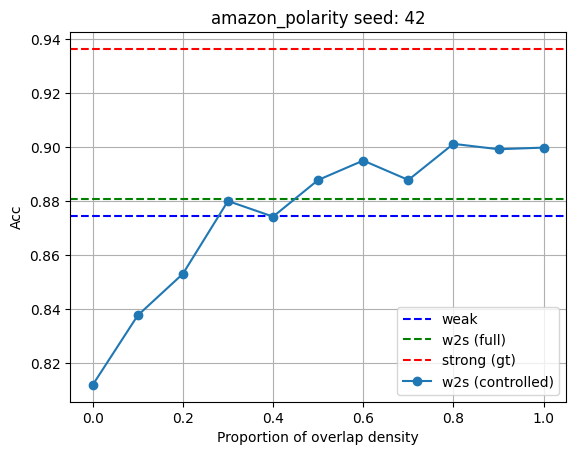

In [ ]:
probe_name = "logreg"
probe_cfg = LogisticProbeConfig()

# Load activations
weak_acts_dir = Path(cfg.results_folder) / cfg_name / "weak_activations"
strong_acts_dir = Path(cfg.results_folder) / cfg_name / "strong_activations"

x_weak_train = torch.load(weak_acts_dir / f"weak_train.pt", map_location="cuda")
x_strong_train = torch.load(strong_acts_dir / f"strong_train.pt", map_location="cuda")
x_w2s_train_for_pseudolabeling = torch.load(weak_acts_dir / f"strong_train.pt", map_location="cuda")
x_weak_test = torch.load(weak_acts_dir / f"test.pt", map_location="cuda")
x_strong_test = torch.load(strong_acts_dir / f"test.pt", map_location="cuda")
y_weak_train = torch.tensor(splits["weak_train"]["labels"], device="cuda")
y_strong_train = torch.tensor(splits["strong_train"]["labels"], device="cuda")
y_test = torch.tensor(splits["test"]["labels"], device="cuda")

print(f"Weak acts shape: {x_weak_train.shape}")
print(f"Strong acts shape: {x_strong_train.shape}")

# Train weak, strong, and w2s probes
weak_probe = PROBES[probe_name](probe_cfg) # ==LogisticProbe(LogisticProbeConfig())
weak_probe.fit(x_weak_train, y_weak_train)

strong_probe = PROBES[probe_name](probe_cfg)
strong_probe.fit(x_strong_train, y_strong_train)

y_w2s_train_for_pseudolabeling = weak_probe.predict(x_w2s_train_for_pseudolabeling)
w2s_probe = PROBES[probe_name](probe_cfg)
w2s_probe.fit(x_strong_train, torch.tensor(y_w2s_train_for_pseudolabeling, device="cuda"))

# Compute accuracy for weak probe on test set
weak_preds = weak_probe.predict(x_weak_test)
strong_preds = strong_probe.predict(x_strong_test)
w2s_preds = w2s_probe.predict(x_strong_test)

weak_test_labels = torch.tensor(splits["test"]["labels"], device="cuda")
weak_test_accuracy = (weak_preds.round() == weak_test_labels).float().mean().item()

# Compute accuracy for strong probe on test set
strong_test_labels = torch.tensor(splits["test"]["labels"], device="cuda")
strong_test_accuracy = (strong_preds.round() == strong_test_labels).float().mean().item()

# Compute accuracy for w2s probe on test set
w2s_test_labels = torch.tensor(splits["test"]["labels"], device="cuda")
w2s_test_accuracy = (w2s_preds.round() == w2s_test_labels).float().mean().item()

pgr = (w2s_test_accuracy - weak_test_accuracy) / (strong_test_accuracy - weak_test_accuracy)

print(f"Weak probe test accuracy: {weak_test_accuracy:.4f}")
print(f"Strong probe test accuracy: {strong_test_accuracy:.4f}")
print(f"W2S probe test accuracy: {w2s_test_accuracy:.4f}")
print(f"PGR: {pgr:.4f}")


### Overlap selection ###

y_w2s_train_for_pseudolabeling = y_w2s_train_for_pseudolabeling.cpu().detach().numpy()
x_strong_train = x_strong_train.cpu().detach().numpy()

confidence_w2s_train = 2*np.abs(y_w2s_train_for_pseudolabeling-0.5)
# Sort confidence scores
sorted_confidence = np.sort(confidence_w2s_train)

# Perform change point detection
model = Binseg(model="l2").fit(sorted_confidence.reshape(-1, 1))
change_points = model.predict(n_bkps=1)[0]

# Use the detected change point as the threshold
confidence_threshold = sorted_confidence[change_points]
low_confidence_indices = np.where(confidence_w2s_train <= confidence_threshold)[0]
high_confidence_indices = np.where(confidence_w2s_train > confidence_threshold)[0]

x_w2s_train = x_strong_train # shared feature set
y_w2s_train = y_w2s_train_for_pseudolabeling
x_w2s_train_hard = x_strong_train[low_confidence_indices]
y_w2s_train_hard = y_w2s_train_for_pseudolabeling[low_confidence_indices]
x_w2s_train_easy_or_overlap = x_strong_train[high_confidence_indices]
y_w2s_train_easy_or_overlap = y_w2s_train_for_pseudolabeling[high_confidence_indices]

# Normalize the data
x_w2s_train_hard_normalized = x_w2s_train_hard / np.linalg.norm(x_w2s_train_hard, axis=1, keepdims=True)
x_w2s_train_easy_or_overlap_normalized = x_w2s_train_easy_or_overlap / np.linalg.norm(x_w2s_train_easy_or_overlap, axis=1, keepdims=True)

# Calculate alignment scores
align_scores = np.abs(x_w2s_train_easy_or_overlap_normalized @ x_w2s_train_hard_normalized.T).max(axis=1)

# Apply change point detection to decide threshold for align scores
sorted_align_scores = np.sort(align_scores)

# Perform change point detection
model = Binseg(model="l2").fit(sorted_align_scores.reshape(-1, 1))
change_points = model.predict(n_bkps=1)[0]

# Use the detected change point as the threshold
align_score_threshold = sorted_align_scores[change_points]
overlap_indices = np.where(align_scores >= align_score_threshold)[0]
nonoverlap_indices = np.where(align_scores < align_score_threshold)[0]

# Extract overlapping & non-overlapping data points
x_w2s_train_overlap = x_w2s_train_easy_or_overlap[overlap_indices]
y_w2s_train_overlap = y_w2s_train_easy_or_overlap[overlap_indices]
x_w2s_train_nonoverlap = np.concatenate([x_w2s_train_easy_or_overlap[nonoverlap_indices], x_w2s_train_hard])
y_w2s_train_nonoverlap = np.concatenate([y_w2s_train_easy_or_overlap[nonoverlap_indices], y_w2s_train_hard])


### Save overlapping data points ###
# Save overlapping data points from the dataset splits | Can be used for further model fine-tuning
w2s_train_overlap_ds = splits["strong_train"].select(overlap_indices)
w2s_train_overlap_ds.save_to_disk(str(Path(cfg.results_folder) / cfg_name / "w2s_train_overlap_ds"))


### Run mixing experiments ###
# To prove that Overlap Density is a good proxy for the quality of the weak supervision with given dataset

# Init variables
acc_list = []
wl_dataset_size = min(len(x_w2s_train_overlap), len(x_w2s_train_nonoverlap))
w2s_train_indices = np.arange(len(x_w2s_train))
w2s_train_sampled_indices = np.random.choice(w2s_train_indices, size=wl_dataset_size, replace=False)

# Sample training data
x_w2s_train_sampled = x_w2s_train[w2s_train_sampled_indices]
y_w2s_train_sampled = y_w2s_train[w2s_train_sampled_indices]
strong_sampled_probe = PROBES[probe_name](probe_cfg)
x_w2s, y_w2s = torch.tensor(x_w2s_train_sampled, device="cuda"), torch.tensor(y_w2s_train_sampled, device="cuda")
strong_sampled_probe.fit(x_w2s, y_w2s)
strong_sampled_preds = strong_sampled_probe.predict(x_strong_test)
strong_sampled_acc = (strong_sampled_preds.round() == y_test).float().mean().item()

# Define proportion list and indices
proportion_list = np.arange(0, 1.01, 0.1)
overlap_indices_full = np.arange(len(x_w2s_train_overlap))
nonoverlap_indices_full = np.arange(len(x_w2s_train_nonoverlap))

# Run experiments for each overlap proportion
for overlap_portion in tqdm(proportion_list):
    if overlap_portion==0:
        sample_indices = np.random.choice(nonoverlap_indices_full, size=wl_dataset_size, replace=False).tolist()
        x_w2s = x_w2s_train_nonoverlap[sample_indices]
        y_w2s = y_w2s_train_nonoverlap[sample_indices]
    elif overlap_portion==1:
        sample_indices = np.random.choice(overlap_indices_full, size=wl_dataset_size, replace=False).tolist()
        x_w2s = x_w2s_train_overlap[sample_indices]
        y_w2s = y_w2s_train_overlap[sample_indices]
    else:   
        overlap_portion = np.round(overlap_portion, 1)
        nonoverlap_size = int(wl_dataset_size * (1-overlap_portion))
        overlap_size = int(wl_dataset_size * (overlap_portion))

        nonoverlap_indices = np.random.choice(nonoverlap_indices_full, size=nonoverlap_size, replace=False).tolist()
        overlap_indices = np.random.choice(overlap_indices_full, size=overlap_size, replace=False).tolist()
        
        x_w2s = np.concatenate([x_w2s_train_nonoverlap[nonoverlap_indices], x_w2s_train_overlap[overlap_indices]])
        y_w2s = np.concatenate([y_w2s_train_nonoverlap[nonoverlap_indices], y_w2s_train_overlap[overlap_indices]])
        
    # Train and evaluate probe
    w2s_overlap_probe = PROBES[probe_name](probe_cfg)
    x_w2s, y_w2s = torch.tensor(x_w2s, device="cuda"), torch.tensor(y_w2s, device="cuda")
    w2s_overlap_probe.fit(x_w2s, y_w2s)
    w2s_overlap_preds = w2s_overlap_probe.predict(x_strong_test)
    w2s_overlap_acc = (w2s_overlap_preds.round() == y_test).float().mean().item()
    acc_list.append(w2s_overlap_acc)

# Plot results
plt.axhline(y=weak_test_accuracy, color='b', linestyle='--', label='weak')
plt.axhline(y=w2s_test_accuracy, color='g', linestyle='--', label='w2s (full)') # ws is the same as w2s but for the whole dataset (not sampled)
plt.axhline(y=strong_test_accuracy, color='r', linestyle='--', label='strong (gt)')
plt.plot(proportion_list, acc_list, 'o-', label='w2s (controlled)')
plt.xlabel('Proportion of overlap density')
plt.ylabel('Acc')
plt.title(cfg.dataset+f' seed: {cfg.seed}')
plt.legend()
plt.grid()
plt.show()

# Save the results
result = {
    'dataset_name': cfg.dataset,
    'seed': cfg.seed,
    'weak_test_accuracy': weak_test_accuracy,
    'strong_test_accuracy': strong_test_accuracy,
    'w2s_test_accuracy': w2s_test_accuracy,
    'pgr': pgr,
    'strong_sampled_acc': strong_sampled_acc,
    'acc_list': acc_list,
}

if not os.path.exists(f'./results/linear_probing_eval/'):
    os.makedirs(f'./results/linear_probing_eval/')

with open(f'./results/linear_probing_eval/overlap_probing_results_{cfg.dataset}_{cfg.seed}.json', 'w') as f:
    json.dump(result, f)

As a relatively simple additional functionality, it's possible to create a code to extract specific amount of overlapping data points (e.g. researcher wants 5K overlapping data points to fine-tune strong model)

## Future work
As a suggestion for a future work, overlap data points can be used to fine-tune SOTA model and:
1. Synthesize more overlapping data points using data augmentation techniques
2. Use the synthesized data points for better Weak-to-Strong supervision

We also may need more research to understand what data features are causing the overlap to happen in a first place, and if that's possible to maximize overlap density (of high overlap regime) in any given dataset.


## Data Selection with Linear Probing

/tmp/ipykernel_997/1045605498.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_weak_train = torch.load(weak_acts_dir / f"weak_train.pt", map_location="cuda")
/tmp/ipyk

Weak acts shape: torch.Size([5000, 896])
Strong acts shape: torch.Size([5000, 4096])
Setting up sources...
Running Optimal...


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


Running UCB...


100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Running Random...


100%|██████████| 50/50 [01:50<00:00,  2.20s/it]


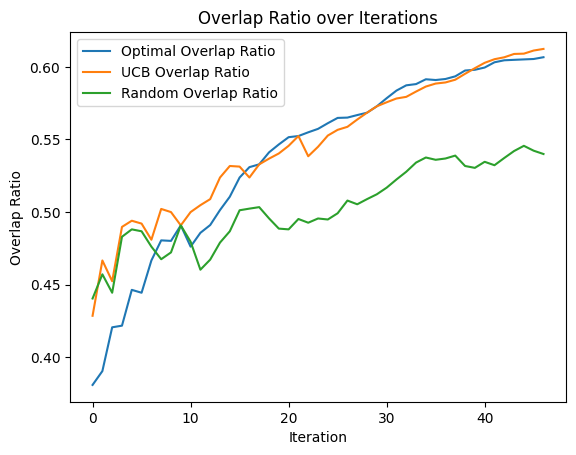

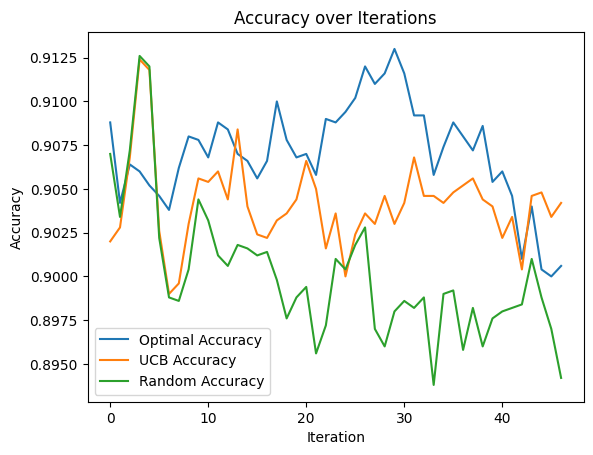

Empty DataFrame
Columns: []
Index: []


In [ ]:
probe_name = "logreg"
probe_cfg = LogisticProbeConfig()


overlap_sampling_ratio_list = [0.1, 0.9]
K = len(overlap_sampling_ratio_list)
hard_sampling_ratio_list = [1/K for _ in range(K)]
easy_sampling_ratio_list = [1/K for _ in range(K)]
T = 50

# Load activations
weak_acts_dir = Path(cfg.results_folder) / cfg_name / "weak_activations"
strong_acts_dir = Path(cfg.results_folder) / cfg_name / "strong_activations"

x_weak_train = torch.load(weak_acts_dir / f"weak_train.pt", map_location="cuda")
x_strong_train = torch.load(strong_acts_dir / f"strong_train.pt", map_location="cuda")
x_w2s_train_for_pseudolabeling = torch.load(weak_acts_dir / f"strong_train.pt", map_location="cuda")
x_weak_test = torch.load(weak_acts_dir / f"test.pt", map_location="cuda")
x_strong_test = torch.load(strong_acts_dir / f"test.pt", map_location="cuda")
y_weak_train = torch.tensor(splits["weak_train"]["labels"], device="cuda")
y_strong_train = torch.tensor(splits["strong_train"]["labels"], device="cuda")
y_test = torch.tensor(splits["test"]["labels"], device="cuda")

print(f"Weak acts shape: {x_weak_train.shape}")
print(f"Strong acts shape: {x_strong_train.shape}")

# Train weak probe
weak_model = PROBES[probe_name](probe_cfg)
weak_model.fit(x_weak_train, y_weak_train)

with torch.no_grad():
    y_w2s_train_for_pseudolabeling = weak_model.predict(x_w2s_train_for_pseudolabeling)

# Compute accuracy for weak probe on test set
with torch.no_grad():
    weak_preds = weak_model.predict(x_weak_test)
    weak_test_labels = torch.tensor(splits["test"]["labels"], device="cuda")
weak_test_accuracy = (weak_preds.round() == weak_test_labels).float().mean().item()

y_w2s_train_for_pseudolabeling = y_w2s_train_for_pseudolabeling.cpu().detach().numpy()
x_strong_train = x_strong_train.cpu().detach().numpy()
y_strong_train = y_strong_train.cpu().detach().numpy()

detected_hard_indices, detected_nonhard_indices = detect_hard_nonhard(x_w2s_train_for_pseudolabeling, y_w2s_train_for_pseudolabeling)


x_w2s_train_hard = x_strong_train[detected_hard_indices]
y_w2s_train_hard = y_strong_train[detected_hard_indices]
x_w2s_train_nonhard = x_strong_train[detected_nonhard_indices]
y_w2s_train_nonhard = y_strong_train[detected_nonhard_indices]
detected_easy_indices, detected_overlap_indices = detect_overlap_easy(x_w2s_train_nonhard, x_w2s_train_hard, x_w2s_train_nonhard, detected_nonhard_indices) # Fixed | Added X_nonhard_augmented=x_w2s_train_nonhard as it was missing
x_w2s_train_overlap = x_strong_train[detected_overlap_indices]
y_w2s_train_overlap = y_strong_train[detected_overlap_indices]
x_w2s_train_nonoverlap = np.concatenate([x_strong_train[detected_easy_indices], x_strong_train[detected_hard_indices]])
y_w2s_train_nonoverlap = np.concatenate([y_strong_train[detected_easy_indices], y_strong_train[detected_hard_indices]])

# Random partition x_strong based on overlap sampling ratio
np.random.seed(cfg.seed)
np.random.shuffle(detected_easy_indices)
np.random.shuffle(detected_hard_indices)
np.random.shuffle(detected_overlap_indices)

detected_overlap_partition = partition_indices_with_ratio(detected_overlap_indices, overlap_sampling_ratio_list, cfg.seed)
detected_easy_partition = partition_indices_with_ratio(detected_easy_indices, easy_sampling_ratio_list, cfg.seed)
detected_hard_partition = partition_indices_with_ratio(detected_hard_indices, hard_sampling_ratio_list, cfg.seed)

# Loop to decie number_of_samples_per_round
sample_size_list = []
overlap_density_list = []
for easy_indices, hard_indices, overlap_indices in zip(detected_easy_partition, detected_hard_partition, detected_overlap_partition):
    sample_indices = np.concatenate([easy_indices, hard_indices, overlap_indices])
    sample_size_list.append(sample_indices.shape[0])
    overlap_density_list.append(overlap_indices.shape[0] / sample_indices.shape[0])
min_sample_size = min(sample_size_list)
number_of_samples_per_round = int(min_sample_size / T)


############## Bandit #############
# Setup sources
print("Setting up sources...")
arms = setup_arms(K, detected_easy_partition, detected_hard_partition, detected_overlap_partition, x_strong_train, x_w2s_train_for_pseudolabeling, y_strong_train, overlap_density_list, number_of_samples_per_round, T, cfg.seed)
opt_o_log = []
opt_acc_log = []
opt_acc_overlap_only_log = []
ucb_o_log = []
ucb_acc_log = []
ucb_acc_overlap_only_log = []
ucb_ucb_log =[]
random_o_log = []
random_acc_log = []
random_acc_overlap_only_log = []

### Run Bandit: Optimal
print("Running Optimal...")

opt_source = np.argmax(overlap_sampling_ratio_list)
opt_tracker = StrategyTracker(x_strong_test, y_test, probe_name, probe_cfg)

for i in tqdm(range(T)):
    source = opt_source
    arm = arms[source]
    X_train_sample, X_weak_train_sample, y_train_sample = arm.get_samples()
    with torch.no_grad():
        y_train_sample_pseudo = weak_model.predict(X_weak_train_sample)
    
    partition_dict = detect_and_partition(X_train_sample, y_train_sample, y_train_sample_pseudo, opt_tracker)
    arm.update(partition_dict)
    
    opt_tracker.update_samples(partition_dict)
    opt_o_log.append(opt_tracker.get_est_overlap_ratio())
    opt_acc_log.append(opt_tracker.train_and_eval())
    opt_acc_overlap_only_log.append(opt_tracker.train_and_eval_overlap_only())

### UCB
print("Running UCB...")
arms = setup_arms(K, detected_easy_partition, detected_hard_partition, detected_overlap_partition, x_strong_train, x_w2s_train_for_pseudolabeling, y_strong_train, overlap_density_list, number_of_samples_per_round, T, cfg.seed)
ucb_tracker = StrategyTracker(x_strong_test, y_test, probe_name, probe_cfg)

for i in tqdm(range(K)):
    source = i
    arm = arms[source]
    X_train_sample, X_weak_train_sample, y_train_sample = arm.get_samples()
    with torch.no_grad():
        y_train_sample_pseudo = weak_model.predict(X_weak_train_sample)
    
    partition_dict = detect_and_partition(X_train_sample, y_train_sample, y_train_sample_pseudo, ucb_tracker)
    arm.update(partition_dict)
    ucb_tracker.update_samples(partition_dict)
    ucb_o_log.append(ucb_tracker.get_est_overlap_ratio())
    ucb_acc_log.append(ucb_tracker.train_and_eval())
    ucb_acc_overlap_only_log.append(ucb_tracker.train_and_eval_overlap_only())

for i in tqdm(range(T-K)):
    ucbs = []
    for k in range(K):
        ucbs.append(arms[k].compute_ucb())
    ucb_ucb_log.append(ucbs)
    source = np.argmax(ucbs)
    arm = arms[source]
    X_train_sample, X_weak_train_sample, y_train_sample = arm.get_samples()
    with torch.no_grad():
        y_train_sample_pseudo = weak_model.predict(X_weak_train_sample)
    
    partition_dict = detect_and_partition(X_train_sample, y_train_sample, y_train_sample_pseudo, ucb_tracker)
    
    arm.update(partition_dict)
    ucb_tracker.update_samples(partition_dict)
    ucb_o_log.append(ucb_tracker.get_est_overlap_ratio())
    ucb_acc_log.append(ucb_tracker.train_and_eval())
    ucb_acc_overlap_only_log.append(ucb_tracker.train_and_eval_overlap_only())

### Random
print("Running Random...")
arms = setup_arms(K, detected_easy_partition, detected_hard_partition, detected_overlap_partition, x_strong_train, x_w2s_train_for_pseudolabeling, y_strong_train, overlap_density_list, number_of_samples_per_round, T, cfg.seed)
random_tracker = StrategyTracker(x_strong_test, y_test, probe_name, probe_cfg)

for i in tqdm(range(T)):
    source = np.random.randint(K)
    arm = arms[source]
    X_train_sample, X_weak_train_sample, y_train_sample = arm.get_samples()
    with torch.no_grad():
        y_train_sample_pseudo = weak_model.predict(X_weak_train_sample)
    partition_dict = detect_and_partition(X_train_sample, y_train_sample, y_train_sample_pseudo, random_tracker)
    arm.update(partition_dict)
    random_tracker.update_samples(partition_dict)
    random_o_log.append(random_tracker.get_est_overlap_ratio())
    random_acc_log.append(random_tracker.train_and_eval())
    random_acc_overlap_only_log.append(random_tracker.train_and_eval_overlap_only())


### Plot results ###
# Plot overlap ratio logs
# plt.figure(figsize=(12, 6))
plt.plot(opt_o_log[3:], label='Optimal Overlap Ratio')
plt.plot(ucb_o_log[3:], label='UCB Overlap Ratio')
plt.plot(random_o_log[3:], label='Random Overlap Ratio')
plt.xlabel('Iteration')
plt.ylabel('Overlap Ratio')
plt.title(f'Overlap Ratio over Iterations for {cfg.dataset}_{cfg.seed}')
plt.legend()
plt.show()

# Plot accuracy logs
# plt.figure(figsize=(12, 6))
plt.plot(opt_acc_log[3:], label='Optimal Accuracy')
plt.plot(ucb_acc_log[3:], label='UCB Accuracy')
plt.plot(random_acc_log[3:], label='Random Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy over Iterations')
plt.legend()
plt.show()


### Save results ###
result = {
    'seed': cfg.seed,
    'dataset_name': cfg.dataset,
    'opt_o_log': opt_o_log,
    'ucb_o_log': ucb_o_log,
    'random_o_log': random_o_log,
    'opt_acc_log': opt_acc_log,
    'ucb_acc_log': ucb_acc_log,
    'random_acc_log': random_acc_log,
    'ucb_ucb_log': ucb_ucb_log,
    'overlap_density_list': overlap_density_list,
    'min_sample_size': min_sample_size,
    'number_of_samples_per_round': number_of_samples_per_round,
}

if not os.path.exists(f'./results/data_selection_linear_probing_eval/'):
    os.makedirs(f'./results/data_selection_linear_probing_eval/')

with open(f'./results/data_selection_linear_probing_eval/data_selection_with_linear_probing_results_{cfg.dataset}_{cfg.seed}.json', 'w') as f:
    json.dump(result, f)